In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree
from numba import njit, prange
from scipy.interpolate import interp1d
import matplotlib as mpl
from scipy.optimize import root_scalar
import glob

from rbf.interpolate import KNearestRBFInterpolant
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

time_conv = 977.79222167

In [75]:
def read_bar_prop(name):
    prefix = '/n/home01/abeane/starbar/plots/'
    prefix_bar_prop = prefix + 'bar_prop/data/'
    
    fin = prefix_bar_prop + 'bar_prop_' + name + '.hdf5'
    h5in = h5.File(fin, mode='r')
    
    out = {}
    for key in h5in.keys():
        out[key] = np.array(h5in[key])
    
    h5in.close()
    
    return out

def get_nchunk_in_bar(name):
    prefix = '/n/home01/abeane/starbar/plots/'
    prefix_in_bar = prefix + 'in_bar/data/'
    
    nchunk = len(glob.glob(prefix_in_bar + 'in_bar_' + name + '/in_bar_' + name + '.*.hdf5'))
    return nchunk

def read_in_bar(name, chunk_idx):
    prefix = '/n/home01/abeane/starbar/plots/'
    prefix_in_bar = prefix + 'in_bar/data/'
    
    fin = prefix_in_bar + 'in_bar_' + name + '/in_bar_' + name + '.' + str(chunk_idx) + '.hdf5'
    h5in = h5.File(fin, mode='r')
    
    out = {}
    for key in h5in.keys():
        out[key] = np.array(h5in[key])
    
    h5in.close()
    return out

def read_all_in_bar(name):
    nchunk = get_nchunk_in_bar(name)
    
    in_bar_list = []
    for i in tqdm(range(nchunk)):
        in_bar = read_in_bar(name, i)
        in_bar_list.append(in_bar)
    
    return in_bar_list


In [40]:
bar_prop_Nbody4 = read_bar_prop('Nbody-lvl4')
bar_prop_Nbody3 = read_bar_prop('Nbody-lvl3')
bar_prop_gas4 = read_bar_prop('phantom-vacuum-Sg20-Rc3.5-lvl4')
bar_prop_gas3 = read_bar_prop('phantom-vacuum-Sg20-Rc3.5-lvl3')

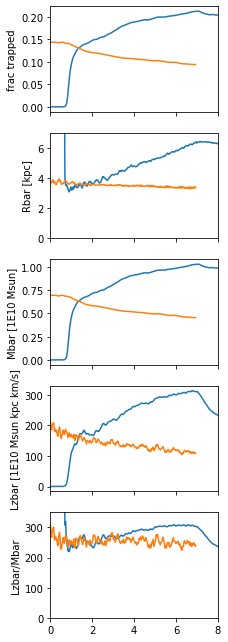

In [44]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(3, 9*5/4))

bar_prop = bar_prop_Nbody3['bar_prop']
bar_prop2 = bar_prop_gas3['bar_prop']


ax[0].plot(bar_prop[:,0], bar_prop[:,1])
ax[0].plot(bar_prop2[:,0], bar_prop2[:,1])

ax[1].plot(bar_prop[:,0], bar_prop[:,2])
ax[1].plot(bar_prop2[:,0], bar_prop2[:,2])

ax[2].plot(bar_prop[:,0], bar_prop[:,3])
ax[2].plot(bar_prop2[:,0], bar_prop2[:,3])

ax[3].plot(bar_prop[:,0], bar_prop[:,4])
ax[3].plot(bar_prop2[:,0], bar_prop2[:,4])

ax[4].plot(bar_prop[:,0], bar_prop[:,4]/bar_prop[:,3])
ax[4].plot(bar_prop2[:,0], bar_prop2[:,4]/bar_prop2[:,3])

ax[0].set(xlim=(0, 8))

ax[0].set(ylabel='frac trapped')
ax[1].set(ylabel='Rbar [kpc]', ylim=(0, 7))
ax[2].set(ylabel='Mbar [1E10 Msun]')
ax[3].set(ylabel='Lzbar [1E10 Msun kpc km/s]')
ax[4].set(ylabel='Lzbar/Mbar', ylim=(0, 350))


plt.show()


In [76]:
in_bar_Nbody4 = read_all_in_bar('Nbody-lvl4')
in_bar_Nbody3 = read_all_in_bar('Nbody-lvl3')
in_bar_gas4 = read_all_in_bar('phantom-vacuum-Sg20-Rc3.5-lvl4')
in_bar_gas3 = read_all_in_bar('phantom-vacuum-Sg20-Rc3.5-lvl3')

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [73]:
def get_frac_from_idx(in_bar_tot, idx=500):

    nsnap = len(in_bar_tot[0]['idx_list'])

    N_inbar = np.zeros(nsnap)
    N_tot = np.zeros(nsnap)
    N_fromidx = np.zeros(nsnap)
    idx = 500

    for i in tqdm(range(len(in_bar_tot))):
        in_bar_idx = in_bar_tot[i]['in_bar'][idx]
        for j in range(nsnap):
            in_bar = in_bar_tot[i]['in_bar'][j]
        
            N_inbar[j] += len(np.where(in_bar)[0])
            N_tot[j] += len(in_bar)
        
            if j <= idx:
                N_fromidx[j] += len(np.where(in_bar)[0])
            else:
                t = len(np.where(np.logical_and(in_bar, in_bar_idx))[0])
                N_fromidx[j] += t

    frac_inbar = N_inbar / N_tot
    frac_fromidx = N_fromidx / N_tot
    tlist = in_bar_tot[0]['tlist']
    
    return tlist, frac_inbar, frac_fromidx

In [77]:
tlist_N4, finbar_N4, fidx_N4 = get_frac_from_idx(in_bar_Nbody4)
tlist_N3, finbar_N3, fidx_N3 = get_frac_from_idx(in_bar_Nbody3)
tlist_g4, finbar_g4, fidx_g4 = get_frac_from_idx(in_bar_gas4)
tlist_g3, finbar_g3, fidx_g3 = get_frac_from_idx(in_bar_gas3)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

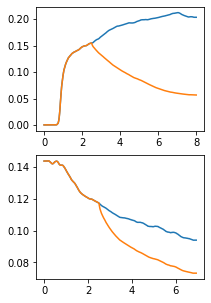

In [78]:
fig, ax = plt.subplots(2, 1, figsize=(3, 5))

ax[0].plot(tlist_N3, finbar_N3)
ax[0].plot(tlist_N3, fidx_N3)

ax[1].plot(tlist_g3, finbar_g3)
ax[1].plot(tlist_g3, fidx_g3)

plt.show()

In [ ]:
def get_left_new(in_bar_tot, name, idx0=500, idx1=550):
    phase_space_path = 
    
    pos_left = np.array([])
    vel_left = np.array([])
    pos_new  = np.array([])
    vel_new  = np.array([])
    
    for i in range(len(in_bar_tot))
        in_bar_idx0 = in_bar_tot[i]['in_bar'][idx0]
        in_bar_idx1 = in_bar_tot[i]['in_bar'][idx1]
        
        bool_left = np.logical_and(in_bar_idx0, np.logical_not(in_bar_idx1))
        bool_new = np.logical_and(np.logical_not(in_bar_idx0), in_bar_idx1)
        
        
    